# Movie Review Classification

Here we show how a computer can tell apart good and bad movie reviews. To do so, we create a "classifier": A device that learns data categorization patterns from a

First we get a lot of movie reviews and label them as good or bad. We will use these real reviews to train the classifier.

In [1]:
# SETUP MAGIC
f = open("train.tsv")
cur = -1
all_X = []
all_y = []
for line in f:
    if cur == -1: # Skip first line
        cur += 1
        continue
    parts = line.split('\t')
    if cur < int(parts[1]):
        all_X.append(parts[2])
        all_y.append(int(parts[3]))
        cur += 1

# Split up 0-1: negative, 2(neutral) - skip, 3-4: positive
all_X2 = []
all_y2 = []
all_bad = []
all_good = []
for i in range(len(all_X)):
    if all_y[i] == 2:
        continue
    
    new_y = -1 if all_y[i] < 2 else 1
    
    all_y2.append(new_y)
    all_X2.append(all_X[i])
    
    if new_y == -1:
        all_bad.append(all_X[i])
    else:
        all_good.append(all_X[i])

Here are examples of one negative and one positive movie review from the sample we just loaded:

In [2]:
# A bad example
print "Negative:"
print all_bad[8]
print
# A good one
print "Positive:"
print all_good[9]

Negative:
As inept as big-screen remakes of The Avengers and The Wild Wild West .

Positive:
Best indie of the year , so far .


Now we have to transform the movie review sentences into a format that the computer can understand and process efficiently.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words='english', ngram_range=(1, 3))
vX = vectorizer.fit_transform(all_X2)

print "In human:", all_X2[763]
print "In computer:", vX[763]

In human: Demme finally succeeds in diminishing his stature from Oscar-winning master to lowly studio hack .
In computer:   (0, 2467)	1
  (0, 2490)	1
  (0, 1136)	1
  (0, 1565)	1
  (0, 970)	1
  (0, 1771)	1
  (0, 2840)	1


Just like a teacher gives you problems you've never seen before on a test, we want to save some movie reviews to test the classifier with after we train it.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vX, all_y2, test_size=0.2)


Now it is time to train the classifier. X_train is a list of movie reviews in "computer language" and y_train is a of "good" and "bad labels". We show the classifier both (with the fit) function and it learns the patterns in the data.

In [5]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's see how well the classifier did: we show it movie reviews and it tells us what label it should have. The score shows what percent it got correct.  "something about train and test data"....

In [6]:
# How well we are doing:
print "Accuracy on examples used in training", clf.score(X_train, y_train) * 100, "%"
print "Accuracy on new examples", clf.score(X_test, y_test) * 100, "%"

Accuracy on examples used in training 93.373275236 %
Accuracy on new examples 74.4371822803 %


It may look like the computer did not do very well, but many sentences are confusing. Let's see how it does on specific examples

In [7]:
# Let's look at some specific examples
bad = ["I have never seen a movie so dull and uninspired"]
textVX = vectorizer.transform(bad)
print clf.predict(textVX)

good = ["What a masterpiece, everyone must see it"]
textVX = vectorizer.transform(good)
print clf.predict(textVX)

# User sentence
good = ["User sentence"]
textVX = vectorizer.transform(good)
print clf.predict(textVX)

[-1]
[1]
[-1]


What words would you use to tell apart good and bad movie reviews? (Boring, exhilarating...)
Well, we can see what words computers identified as "good-movie" and "bad-movie":

In [8]:
# What does it mean: -- try to do relative thing instead
terms = [term for _, term in sorted((i, term) for term, i in vectorizer.vocabulary_.iteritems())]
term_weights = sorted(zip(clf.coef_.toarray()[0], terms))
from pprint import pprint

# Top 100 terms:
pprint(term_weights[-10:][::-1])

[(2.0619491291019107, u'harrowing'),
 (1.9219496642777165, u'solid'),
 (1.8905921538299302, u'enjoyable'),
 (1.7567062888254452, u'hilarious'),
 (1.7182460188806457, u'foster'),
 (1.6973135190241189, u'like movie'),
 (1.6826520307762887, u'remarkable'),
 (1.6127549086650148, u'hearts'),
 (1.5884356249224552, u'damn'),
 (1.5870902773257409, u'affection')]


In [9]:
pprint(term_weights[:10])

[(-1.8208262943958919, u'wannabe'),
 (-1.7831519440066961, u'mess'),
 (-1.7557563102933464, u'thinks'),
 (-1.7109058496148726, u'generic'),
 (-1.710178722632798, u'suffers'),
 (-1.6687044301975695, u'stupid'),
 (-1.66257565245804, u'worst'),
 (-1.6398899524425037, u'lacking'),
 (-1.5826545515210539, u'apparent'),
 (-1.5820679904750352, u'busy')]


In [10]:
%matplotlib notebook

In [11]:
import matplotlib.pyplot as plt

In [12]:
import numpy as np

In [13]:
nterms = 50

In [14]:
randpoints = np.random.choice(len(terms), [1, nterms])[0]

In [15]:
randweights = clf.coef_.toarray()[0][randpoints]

In [16]:
randterms = np.array(terms)[randpoints]

<IPython.core.display.Javascript object>


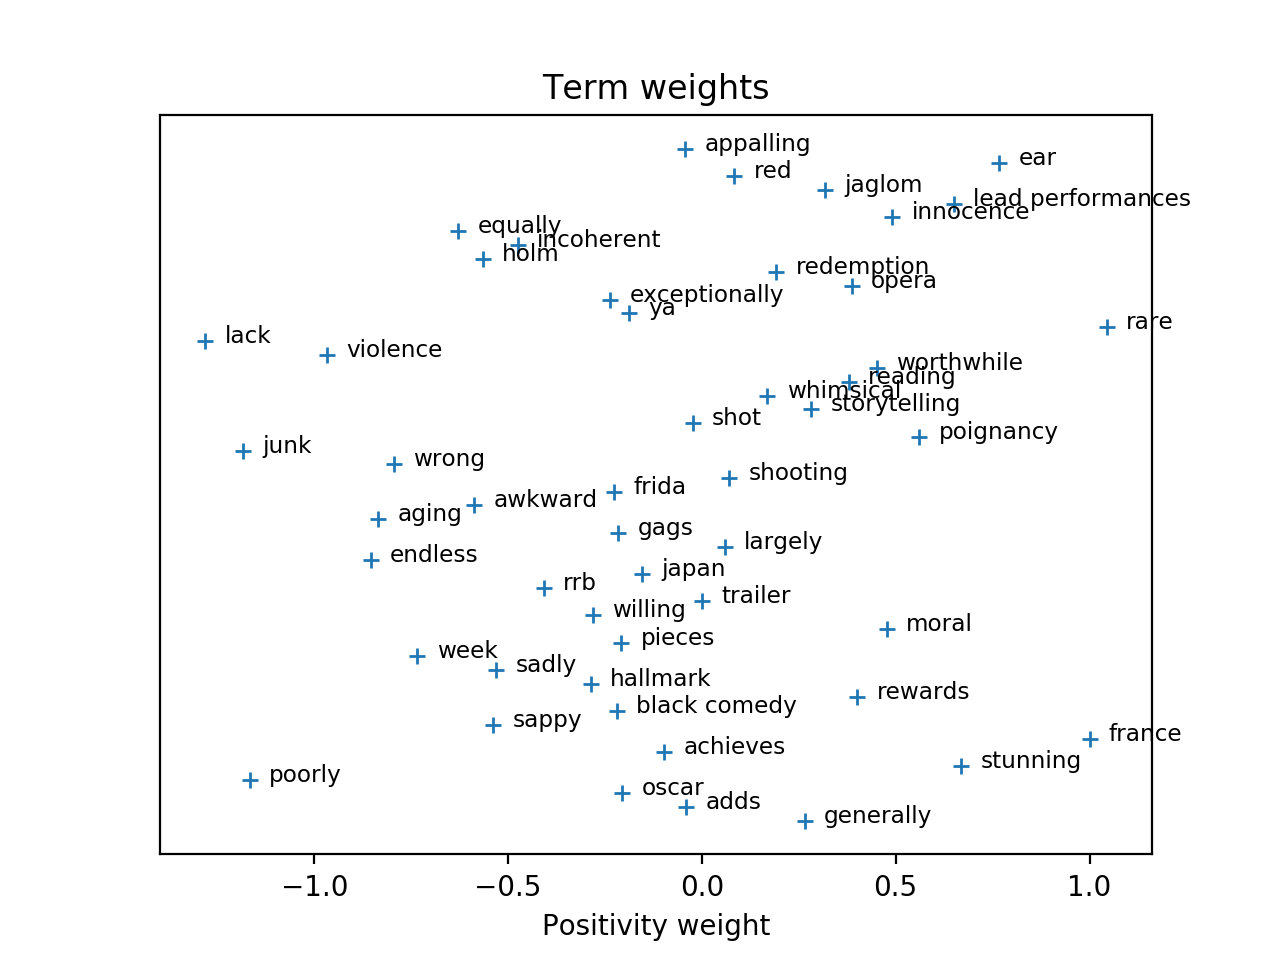

In [17]:
plt.plot(randweights, np.arange(0, nterms), '+')
plt.yticks([])
plt.title('Term weights')
plt.xlabel('Positivity weight')

In [18]:
for i in xrange(nterms):
    plt.text(randweights[i] + 0.05, i - 0.15, randterms[i], size='smaller')

In [19]:
# Some conclusion...